In [1]:
# data managment
import pandas as pd
import numpy as np
import scipy as sp
from lib.RegressorManager import *
from sklearn.externals import joblib
import os.path

# preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# metrics
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score

# plotting
from mpl_toolkits.mplot3d import Axes3D
from lib.PlotLearningCurve import plot_learning_curve
from matplotlib import pyplot as plt
import seaborn as sns
# learning
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection
from sklearn.neural_network import MLPClassifier


sns.set(color_codes=True)

In [2]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
fashion_df = pd.read_csv("datasets/fashion_mnist/fashion-mnist_train.csv")
fashion_df_test = pd.read_csv("datasets/fashion_mnist/fashion-mnist_test.csv")

winemag_df = pd.read_csv("datasets/wine_reviews/winemag-data-130k-v2.csv")

In [4]:
def gen_image(arr, ax=None):
    """
    function to display an mnist image from it's pixels array
    """
    image = np.array(arr, dtype='float')
    pixels = image.reshape((28, 28))
    if ax is None:
        plt.imshow(pixels, cmap='gray')
        plt.show()
    else:
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(pixels, cmap='gray')
    return ax

data preparation
----------------

first we need to clean the dataset, for this we will
 - select relevant columns
 - drop row containing na value (we can afford this because the ratio *number of row / input space dimension* is still good )
 - remove duplicate rows

In [81]:
(n_row, n_col) = fashion_df.values.shape
X_fashion = fashion_df.values[:, 1:n_col]
y_fashion = fashion_df.values[:, 0]
X_fashion_test = fashion_df_test.values[:, 1:n_col]
y_fashion_test = fashion_df_test.values[:, 0]

In [6]:
pipeline_wine = TfidfVectorizer(use_idf=True)

y_winemag = winemag_df['points']
pipeline_wine.fit(winemag_df['description'], y_winemag)
X_winemag = pipeline_wine.transform(winemag_df['description'])

kmeans
-------

/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual

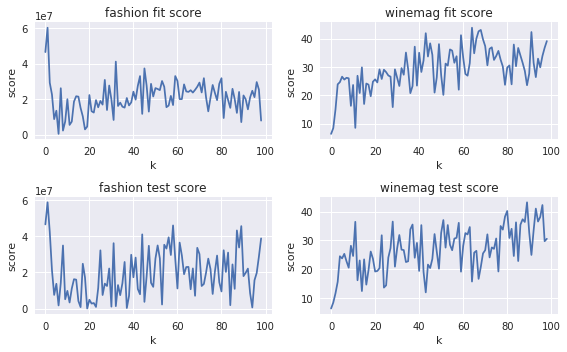

In [7]:
clf = joblib.load('dumps/gridsearch_kmeans_fashion.pkl')
results = pd.DataFrame(data=clf.cv_results_)
clf2 = joblib.load('dumps/gridsearch_kmeans_wine.pkl')
results2 = pd.DataFrame(data=clf2.cv_results_)
fig, ax = plt.subplots(2,2)
fig.set_size_inches(5, fig.get_figheight(), forward=True)
fig.set_size_inches(8, fig.get_figwidth(), forward=True)
ax[0,0].plot(results['std_train_score'])
ax[0,0].set(ylabel='score', xlabel='k',
          title='fashion fit score')
ax[1,0].plot(results['std_test_score'])
ax[1,0].set(ylabel='score', xlabel='k',
          title='fashion test score')
ax[0,1].plot(results2['std_train_score'])
ax[0,1].set(ylabel='score', xlabel='k',
          title='winemag fit score')
ax[1,1].plot(results2['std_test_score'])
ax[1,1].set(ylabel='score', xlabel='k',
          title='winemag test score')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig("figs/kmean_gridsearch.png")
plt.show()

In [8]:
estimator = KMeans(n_clusters=32, n_jobs=-1)
estimator.fit(X_fashion, y_fashion)

KeyboardInterrupt: 

In [9]:
fig, ax = plt.subplots(4, 8)
fig.suptitle('centroid for 32 cluster kmeans')
i = 0
for comp in estimator.cluster_centers_:
    gen_image(comp, ax[i % 4, int(i/4)])
    i += 1
fig.tight_layout()
plt.savefig('figs/kmeans_32_fashion_centroids.png')
plt.show()

<IPython.core.display.Javascript object>

<div id='af677036-608a-4e40-8e4d-e12276758cf3'></div>

AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

In [10]:
estimator = MiniBatchKMeans(n_clusters=1000, batch_size=1000)
estimator.fit(X_winemag, y_winemag)

KeyboardInterrupt: 

In [11]:
import random
print(np.sqrt(np.var(np.vectorize(len)(pipeline_wine.inverse_transform(estimator.cluster_centers_)))))
for i in range(3):
    center = random.choice(estimator.cluster_centers_)
    print(pipeline_wine.inverse_transform(center)[0])


AttributeError: 'MiniBatchKMeans' object has no attribute 'cluster_centers_'

EM
--

In [74]:
clf = joblib.load('dumps/gridsearch_em_fashion.pkl')

/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual

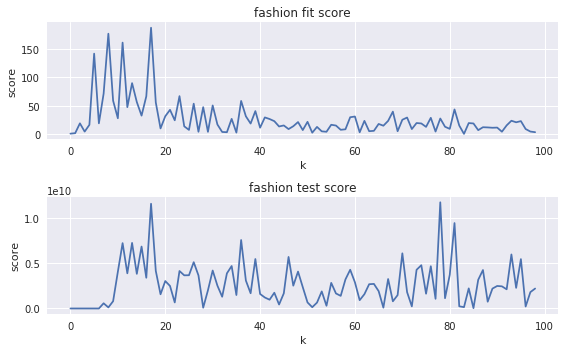

In [75]:
results = pd.DataFrame(data=clf.cv_results_)
fig, ax = plt.subplots(2,1)
fig.set_size_inches(5, fig.get_figheight(), forward=True)
fig.set_size_inches(8, fig.get_figwidth(), forward=True)
ax[0].plot(results['std_train_score'])
ax[0].set(ylabel='score', xlabel='k',
          title='fashion fit score')
ax[1].plot(results['std_test_score'])
ax[1].set(ylabel='score', xlabel='k',
          title='fashion test score')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig("figs/em_gridsearch.png")
plt.show()

In [14]:
estimator = joblib.load('dumps/em_16_fashion.pkl')

In [15]:

if hasattr(estimator, 'cluster_centers_'):
    components_ = estimator.cluster_centers_
elif hasattr(estimator, 'components_'):
    components_ = estimator.components_
else:
    components_ = estimator.means_
fig, ax = plt.subplots(4, 4)
i = 0
for comp in components_:
    gen_image(comp, ax[i % 4, int(i/4)])
    i += 1
fig.suptitle('centroids for 16 clusters EM')
#fig.tight_layout()
plt.savefig('figs/EM_16_fashion_centroids.png')
plt.show()

<IPython.core.display.Javascript object>

<div id='b268862d-800d-42b2-8044-d5f3e89a73ea'></div>

In [16]:
(samples, y) = estimator.sample(16)
fig, ax = plt.subplots(4, 4)
fig.suptitle('generated samples from 16 clusters EM')
i = 0
for sample in samples:
    gen_image(sample, ax[i % 4, int(i/4)])
    ax[i % 4, int(i/4)].set(title='score:'+str(int(estimator.score([sample]))))
    i += 1
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('figs/em_16_fashion_generated.png')
plt.show()


<IPython.core.display.Javascript object>

<div id='793569e8-3289-496b-8a7c-b59a519b2957'></div>

space study:
--------------

In [17]:
s = sp.linalg.svd(X_fashion, full_matrices=False, compute_uv=False)

KeyboardInterrupt: 

In [18]:
fig, ax = plt.subplots()
ax.plot(s)
#ax.set_xscale('log')
ax.set(title='Singular values on fashion MNIST')
ax.set_yscale('log')
plt.savefig('figs/fashion_svd.png')
plt.show()

<IPython.core.display.Javascript object>

<div id='8f4c9465-3c7e-4787-8fa1-76d8f63fd6c6'></div>

NameError: name 's' is not defined

In [19]:
s = joblib.load('dumps/wine_sv.pkl')

In [20]:
fig, ax = plt.subplots()
ax.plot(s[::-1])
#ax.set_xscale('log')
ax.set(title='Singular values on fashion MNIST')
ax.set_yscale('log')
plt.savefig('figs/wine_svd.png')
plt.show()

<IPython.core.display.Javascript object>

<div id='cc8bd3a9-0dcb-4b83-aed9-1d19f730d3bb'></div>

PCA
====

In [8]:
pca = PCA(n_components=3, svd_solver='full')
pca.fit(X_fashion)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [21]:
fig = plt.figure()
ax = Axes3D(fig)
low_dim = pca.transform(X_fashion)
ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=y_fashion, s=0.1)
fig.suptitle('PCA reduction of fashion MNIST dataset')
plt.savefig('figs/PCA_3D_MNIST')
plt.show()

<IPython.core.display.Javascript object>

<div id='837eccb5-05a4-4920-9cef-a7854a5da7f3'></div>

NameError: name 'pca' is not defined

In [15]:
fashionPCA36 = PCA(n_components=36, svd_solver='full')
fashionPCA36.fit(X_fashion)

PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [22]:
if hasattr(fashionPCA36, 'cluster_centers_'):
    components_ = fashionPCA36.cluster_centers_
else:
    components_ = fashionPCA36.components_
fig, ax = plt.subplots(6, 6)
i = 0
for comp in components_:
    gen_image(comp, ax[i % 6, int(i/6)])
    i += 1
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle('PCA decomposition of MNIST dataset')
plt.savefig('figs/PCA_36D_MNIST')
plt.show()

NameError: name 'fashionPCA36' is not defined

In [22]:
pca = TruncatedSVD(n_components=3)
pca.fit(X_winemag)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [23]:
fig = plt.figure()
ax = Axes3D(fig)
low_dim = pca.transform(X_winemag)
low_dim
ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=winemag_df['points'], s=0.1)
fig.suptitle('PCA reduction of Winemag dataset')
plt.savefig('figs/PCA_3D_wine')
plt.show()

<IPython.core.display.Javascript object>

<div id='df43ce02-dc06-4143-8c5c-a8cfda73a604'></div>

NameError: name 'pca' is not defined

ICA
===

In [68]:
from scipy.stats import kurtosis

kurt = kurtosis(X_fashion)
print(np.median(kurt))
print(np.max(kurt))
print(np.min(kurt))

-0.7829121268051884
26068.2512809926
-1.7355875213267595


In [33]:
ica = FastICA(n_components=3, algorithm='parallel')
ica.fit(X_fashion, y_fashion)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=3, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
low_dim = ica.transform(X_fashion)
ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=y_fashion, s=0.1)
fig.suptitle('ICA reduction of fashion MNIST dataset')
plt.savefig('figs/ICA_3D_MNIST')
plt.show()

<IPython.core.display.Javascript object>

<div id='82a00fd6-e293-485e-bf6e-a0a7a5e8cac4'></div>

NameError: name 'ica' is not defined

In [54]:
fashionICA36 = FastICA(n_components=36, algorithm='parallel')
fashionICA36.fit(X_fashion, y_fashion)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=36, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [25]:
if hasattr(fashionICA36, 'cluster_centers_'):
    components_ = fashionICA36.cluster_centers_
else:
    components_ = fashionICA36.components_
fig, ax = plt.subplots(6, 6)
i = 0
for comp in components_:
    gen_image(comp, ax[i % 6, int(i/6)])
    i += 1
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle('ICA decomposition of MNIST dataset')
plt.savefig('figs/ICA_36D_MNIST')
plt.show()

NameError: name 'fashionICA36' is not defined

In [ ]:
joblib.load('dumps/ICA_3D_winemag.pkl')
fig = plt.figure()
ax = Axes3D(fig)
low_dim = ica.transform(X_winemag)
ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=y_winemag, s=0.1)
fig.suptitle('ICA reduction of winemag dataset')
plt.savefig('figs/ICA_3D_winemag')
plt.show()

In [ ]:
ica = joblib.load('ICA_36D_winemag.pkl')

In [ ]:
if hasattr(ica, 'cluster_centers_'):
    components_ = ica.cluster_centers_
else:
    components_ = ica.components_
for comp in components_:
    comp = comp.argsort()[-10:][::-1]
    print(pipeline_wine.inverse_transform(comp))

RP
==

In [ ]:
grp = GaussianRandomProjection(n_components=3)
for i in range(3):
    grp.fit(X_fashion)
    fig = plt.figure()
    ax = Axes3D(fig)
    low_dim = grp.transform(X_fashion)
    ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=y_fashion, s=0.05)
    #fig.suptitle('RC reduction of fashion MNIST dataset')
    plt.savefig('figs/RC_3D_MNIST_'+str(i))
    plt.show()

In [27]:
grp = GaussianRandomProjection(n_components=3)
for i in range(3):
    grp.fit(X_winemag)
    fig = plt.figure()
    ax = Axes3D(fig)
    low_dim = grp.transform(X_winemag)
    ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=winemag_df['points'], s=0.05)
    #fig.suptitle('RC reduction of fashion MNIST dataset')
    plt.savefig('figs/RC_3D_wine_'+str(i))
    plt.show()

<IPython.core.display.Javascript object>

<div id='1203df9e-10ba-439d-8b93-8fd36af9a864'></div>

redux + cluster
===============

In [20]:
score_km = joblib.load("dumps/grid_fashion_redux_cluster_score.pkl")
times_km = joblib.load("dumps/grid_fashion_redux_cluster_times.pkl")
score_em = joblib.load("dumps/grid_fashion_redux_cluster_em_score.pkl")
times_em = joblib.load("dumps/grid_fashion_redux_cluster_em_times.pkl")

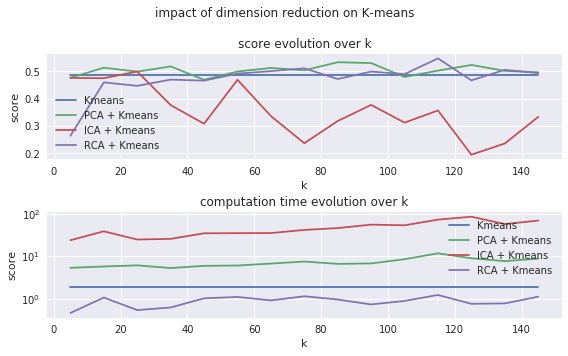

In [64]:
begin = timeit.default_timer()
raw_score = normalized_mutual_info_score(MiniBatchKMeans(n_clusters=10).fit_predict(X_fashion, y_fashion), y_fashion)
raw_time = timeit.default_timer() - begin
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(5, fig.get_figheight(), forward=True)
fig.set_size_inches(8, fig.get_figwidth(), forward=True)
ticks = [x * 10 + 5 for x in range(15)]
ax[0].plot(ticks, [raw_score] * 15, label="Kmeans")
ax[0].plot(ticks, score_km[:, 0], label="PCA + Kmeans")
ax[0].plot(ticks, score_km[:, 1], label="ICA + Kmeans")
ax[0].plot(ticks, score_km[:, 2], label="RCA + Kmeans")
ax[0].set(ylabel='score', xlabel='k',
          title='score evolution over k')
ax[1].plot(ticks, [raw_time] * 15, label="Kmeans")
ax[1].plot(ticks, times_km[:, 0], label="PCA + Kmeans")
ax[1].plot(ticks, times_km[:, 1], label="ICA + Kmeans")
ax[1].plot(ticks, times_km[:, 2], label="RCA + Kmeans")
ax[1].set(ylabel='score', xlabel='k',
          title='computation time evolution over k')
fig.tight_layout()  # Or equivalently,  "plt.tight_layout()"
ax[0].legend()
ax[1].legend()
#ax[0].set_yscale('log')
ax[1].set_yscale('log')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle("impact of dimension reduction on K-means")
plt.savefig("figs/redux_kmeans_gridsearch.png")
plt.show()


DIM REDUX + NN
==============

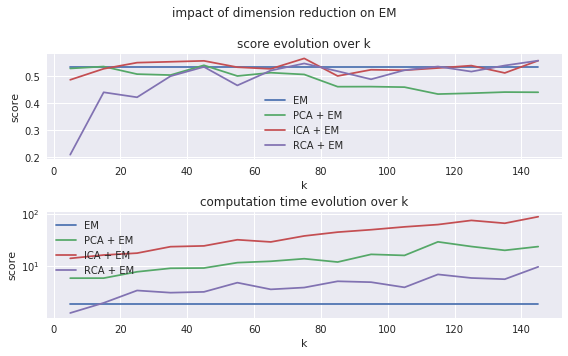

In [ ]:
gm = GaussianMixture(n_components=10, covariance_type='diag')
begin = timeit.default_timer()
gm.fit(X_fashion, y_fashion)
raw_time = timeit.default_timer() - begin


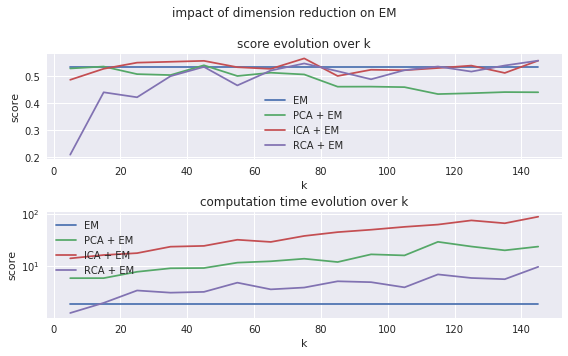

In [66]:
raw_score = normalized_mutual_info_score(gm.predict(X_fashion), y_fashion)
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(5, fig.get_figheight(), forward=True)
fig.set_size_inches(8, fig.get_figwidth(), forward=True)
ticks = [x * 10 + 5 for x in range(15)]
ax[0].plot(ticks, [raw_score] * 15, label="EM")
ax[0].plot(ticks, score_em[:, 0], label="PCA + EM")
ax[0].plot(ticks, score_em[:, 1], label="ICA + EM")
ax[0].plot(ticks, score_em[:, 2], label="RCA + EM")
ax[0].set(ylabel='score', xlabel='k',
          title='score evolution over k')
ax[1].plot(ticks, [raw_time] * 15, label="EM")
ax[1].plot(ticks, times_em[:, 0], label="PCA + EM")
ax[1].plot(ticks, times_em[:, 1], label="ICA + EM")
ax[1].plot(ticks, times_em[:, 2], label="RCA + EM")
ax[1].set(ylabel='score', xlabel='k',
          title='computation time evolution over k')
fig.tight_layout()  # Or equivalently,  "plt.tight_layout()"
ax[0].legend()
ax[1].legend()
#ax[0].set_yscale('log')
ax[1].set_yscale('log')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle("impact of dimension reduction on EM")
plt.savefig("figs/redux_EM_gridsearch.png")
plt.show()


DIM REDUX + NN
==============

In [89]:
nn = joblib.load('dumps/nn_fashion.pkl')
raw_nn_score = nn.score(X_fashion, y_fashion)
raw_nn_score_test = nn.score(X_fashion_test, y_fashion_test)
clf_ica = joblib.load('dumps/grid_nn_fashion.pkl')
clf_pca = joblib.load('dumps/pca_nn_fashion.pkl')
clf_rca = joblib.load('dumps/rp_nn_fashion.pkl')
clf_km = joblib.load('dumps/km_nn_fashion.pkl')
clf_em = joblib.load('dumps/em_nn_fashion.pkl')

In [83]:
raw_nn_score

-3548.272271760019

/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual

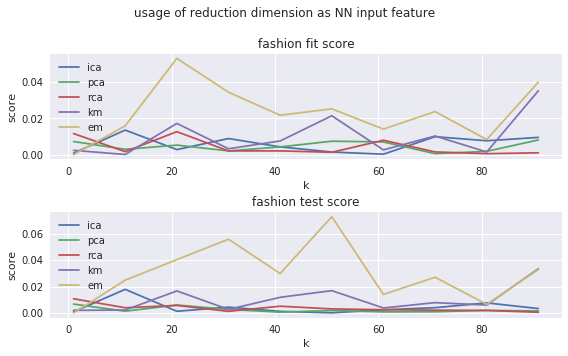

In [98]:
results_ica = pd.DataFrame(data=clf_ica.cv_results_)
results_pca = pd.DataFrame(data=clf_pca.cv_results_)
results_rca = pd.DataFrame(data=clf_rca.cv_results_)
results_km = pd.DataFrame(data=clf_km.cv_results_)
results_em = pd.DataFrame(data=clf_em.cv_results_)
fig, ax = plt.subplots(2,1)
fig.set_size_inches(5, fig.get_figheight(), forward=True)
fig.set_size_inches(8, fig.get_figwidth(), forward=True)
#ax[0].plot(range(1, 100, 10), [raw_nn_score]*10)
ax[0].plot(range(1, 100, 10), results_ica['std_train_score'], label="ica")
ax[0].plot(range(1, 100, 10), results_pca['std_train_score'], label="pca")
ax[0].plot(range(1, 100, 10), results_rca['std_train_score'], label="rca")
ax[0].plot(range(1, 100, 10), results_km['std_train_score'], label="km")
ax[0].plot(range(1, 100, 10), results_em['std_train_score'], label="em")
ax[0].set(ylabel='score', xlabel='k',
          title='fashion fit score')
ax[0].legend()
ax[1].plot(range(1, 100, 10), results_ica['std_test_score'], label="ica")
ax[1].plot(range(1, 100, 10), results_pca['std_test_score'], label="pca")
ax[1].plot(range(1, 100, 10), results_rca['std_test_score'], label="rca")
ax[1].plot(range(1, 100, 10), results_km['std_test_score'], label="km")
ax[1].plot(range(1, 100, 10), results_em['std_test_score'], label="em")
ax[1].set(ylabel='score', xlabel='k',
          title='fashion test score')
ax[1].legend()
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle("usage of reduction dimension as NN input feature")

plt.savefig("figs/redux_nn_gridsearch.png")
plt.show()